In [3]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
# from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit

### TQDM
from tqdm import tqdm_notebook

In [4]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

def ghb_jk_teff(jk,feh):
    '''
    Calculate the photometric Teff of a star using Gonz\'{a}lez Hern\'{a}dez & Bonifacio 2009

    Input:
    -----
        jk: J - K color
    '''
    b = np.array([0.6517,0.6312,0.0168,-0.0381,0.0256,0.0013])

    theta_eff = b[0]+b[1]*jk+b[2]*(jk**2)+b[3]*(jk*feh)+b[4]*feh+b[5]*(feh**2)
    teff = 5040/theta_eff
    self.ghb_teff = teff
    return teff

# PARSEC

In [6]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

<ipython-input-7-81810cf15946>:28: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


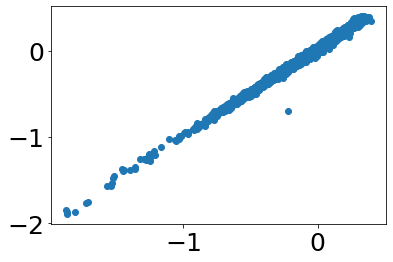

In [7]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = kdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(kdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

# Gaia

In [8]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

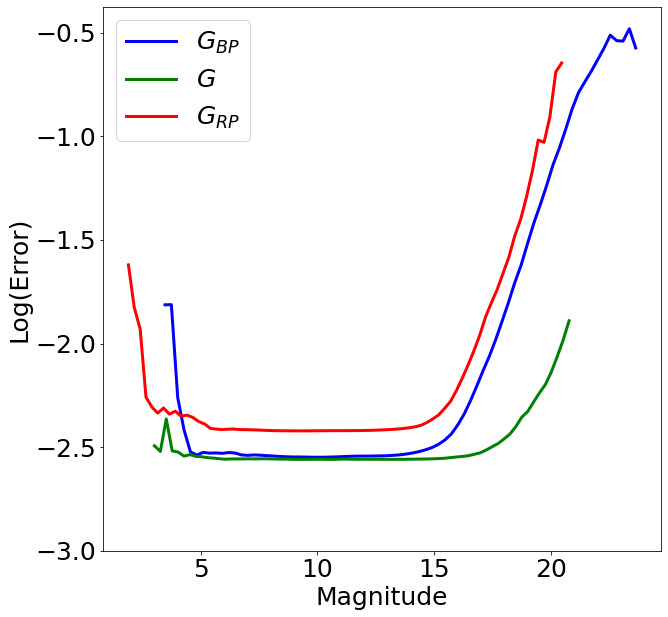

In [9]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = IUS(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

# Get TEFF and Extinction

In [ ]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

#Numpy
import numpy as np

#Scipy
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

class Erebus():
    '''
    Calculate the extinction and/or Teff of a star using its Gaia and 2MASS photometry. 
    Ideally the spectroscopic Teff is already measured. 
    '''
    def __init__(self,feh,photometry,isochrones,alpha=None):
        '''
        Inputs:
        ------
            feh:           2x1 array_like
                           metallicity and error
                        
            photometry:    6x2 array
                           observed photometry and error in the order (BP,G,RP,J,H,K) = (0,1,2,3,4,5)
                        
            isochrones:    array_like
                           Table of PARSEC isochrones with original PARSEC labels 
                           (Preferably an Astropy table)
                           
            alpha:         optional 2x1 array_like
                           alpha abundance and error needed to calculate the Salaris corrected [Fe/H]
        '''
        
        ### Isochrones
        # Salaris Correction to the [Fe/H]
        self.salfeh = np.empty(2)
        if alpha is not None:
            # Asplund et al. 2021 Solar Compostion 
            self.salfeh[0] = feh[0]+np.log10(0.659*(10**(alpha[0]))+0.341)
            self.salfeh[1] = np.sqrt(feh[1]**2+((1-0.341/(0.659*(10**(alpha[0]))+0.341))*alpha[1])**2)
        else:
            self.salfeh = feh
        
        # select isochrone points with metallicity of a star
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh[0]))]
        
        ### Photometry
        # observed photometry
        self.obsphot = photometry
        # effective wavelengths of Gaia and 2MASS bands in microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}

        
    #########################
    ### Utility Functions ###
    #########################
    
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data:  array_like
                   data to search through
                   
            value: float or int
                   value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data:  array_like
                   data to search through
                   
            value: float or int
                   value of interest
        
        Outputs:
        -------
            close1: float or int
                    closest value under the given value
                    
            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        
        Input:
        -----
            data: array_like
                  data to find the median absolute deviation of
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    ############################################
    ### Extinction and Temperature Functions ###
    ############################################

    def fitz_alebv(self,wave):
        '''
        Calculate the A\lambda/E(B-V) value using the Fitzpatrick 1999 extinction law. 
        Rv(=Av/E(B-V)) is assumed to be 3.1.

        Input:
        -----
            wave:  float
                   effective wavelength of the passband of interest

        Output:
        ------
            alebv: float
                   A\lambda/E(B-V)
        '''
        recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])
        alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])

        x=1/wave
        spl = IUS(recip_anchors,alebv_anchors)
        alebv = spl(x)
        return alebv

    def extinction(self,teff,order=2):
        '''

        Calculate the extinction (and intrinsic colors) of a star using its Teff, [Fe/H], and 
        photometry and PARSEC isochrones. For calualtion purposes the Gaia G band is used as the 
        fiducial band. Note that all PARSEC labels are assumed to be unchanged and errors are required 
        for all observed quantities.

        Inputs:
        ------
            teff:       float or 2x1 array_like
                        temperature (and error)

            order:      int
                        order of polynomial to use when calculating the Teff-color relation

        Output:
        ------
            ext:        6x1 array or 6x2 array           
                        extinction in BP,G,RP,J,H, and K bands (with errors if Teff error provided)

            int_colors: 5x1 array or 5x2 array
                        intrinsic colors (BP-G,G-RP,G-J,G-H,G-K) (with errors if Teff error provided)

        '''

        ### PARSEC isochrone Gaia and 2MASS photometry labels to calculate colors
        # The Gaia G band is used as the fiducial band when calculating colors
        blues = np.array(['G_BPmag','Gmag','Gmag','Gmag','Gmag']) 
        reds = np.array(['Gmag','G_RPmag','Jmag','Hmag','Ksmag'])

        # cut all isochrone points further than 100 degrees from its Teff value
        iso_ = self.iso[np.where((self.iso['logTe']>=np.log10(teff[0]-100.))&
                                 (self.iso['logTe']<=np.log10(teff[0]+100.)))]
        
        # check if iso_ is empty and return bad values if true 
        if np.size(iso_)==0:
            ext = 999999.0*np.ones((6,2))
            int_colors = 999999.0*np.ones((6,2))
            return np.array([ext,int_colors],dtype='object')

        ### Modified reddening vector using Fitzpatrick 1999
        fitz_vec = np.array([self.fitz_alebv(self.leff['BP'])/self.fitz_alebv(self.leff['G'])-1.,
                             1.-self.fitz_alebv(self.leff['RP'])/self.fitz_alebv(self.leff['G']),
                             1.-self.fitz_alebv(self.leff['J'])/self.fitz_alebv(self.leff['G']),
                             1.-self.fitz_alebv(self.leff['H'])/self.fitz_alebv(self.leff['G']),
                             1.-self.fitz_alebv(self.leff['K'])/self.fitz_alebv(self.leff['G'])])

        ext_coeffs = np.insert(np.abs(fitz_vec+1.0),1,1.0)

        ### Observed Colors and Errors and teffs with the G band as the fiducial
        obs_colors = np.delete(self.obsphot[:,0]-self.obsphot[1,0],1)
        obs_colors[0] = -1*obs_colors[0]
        obs_colors_err = np.delete(np.sqrt(self.obsphot[:,1]**2+self.obsphot[1,1]**2),1)

        if np.size(teff)==2:
            ### Calculate the Intrinsic colors 
            int_colors = 999999.0*np.ones((5,2))
            for i in range(5):

                # fit Teff-Color relationship and calculate intrinsic colors with errors
                coeffs = np.polyfit(10**iso_['logTe'],iso_[blues[i]]-iso_[reds[i]],order)
                poly_color = np.poly1d(coeffs)

                # derivative of poly_color
                poly_color_deriv = np.poly1d(np.multiply(coeffs[:-1],np.arange(len(coeffs))[::-1][:-1]))

                # calculate the intrinsic colors using the provided Teff
                int_colors[i,0] = poly_color(teff[0])
                int_colors[i,1] = np.abs(poly_color_deriv(teff[0])*teff[1])

            # find the reddening
            color_diff = obs_colors - int_colors[:,0]
            color_diff_err = np.sqrt(np.square(obs_colors_err)+np.square(int_colors[:,1]))

            # find the extinction in the G band with a little bit of linear algebra magic
            a_g = np.dot(fitz_vec,color_diff)/np.linalg.norm(fitz_vec)**2
            a_g_err = np.dot(fitz_vec,color_diff_err)/np.linalg.norm(fitz_vec)**2

            # calculate extinctions in all the bands
            ext = 999999.0*np.ones((6,2))
            ext[:,0] = ext_coeffs*a_g
            ext[:,1] = ext_coeffs*a_g_err
        
        else:
            ### Calculate the Intrinsic colors 
            int_colors = 999999.0*np.ones(5)
            for i in range(5):

                # fit Teff-Color relationship and calculate intrinsic colors with errors
                coeffs = np.polyfit(10**iso_['logTe'],iso_[blues[i]]-iso_[reds[i]],order)
                poly_color = np.poly1d(coeffs)

                # calculate the intrinsic colors using the provided Teff
                int_colors[i,0] = poly_color(teff[0])

            # find the reddening
            color_diff = obs_colors - int_colors[:,0]

            # find the extinction in the G band with a little bit of linear algebra magic
            a_g = np.dot(fitz_vec,color_diff)/np.linalg.norm(fitz_vec)**2

            # calculate extinctions in all the bands
            ext = 999999.0*np.ones(6)
            ext[:,0] = ext_coeffs*a_g

        return np.array([ext, int_colors],dtype='object')
    
    def chi_teff_ext(self,teff0):
        '''
        Calculate the Gaia and 2MASS extinctions as well as the photometric Teff of a star.
        
        Inputs:
        ------
            teff0:      N array
                        array of test Teffs sorted from lowest to highest (ideally initial 
                        guesses clustered around the spectroscopic Teff with spacing roughly 
                        the size of the error)
            
        Outputs:
        -------
            best_teff:  2x1 array
                        interpolated Teff that coresponds to the best chi^sq value with error
                        
            best_ext:   6x2 array
                        extinctions in BP,G,RP,J,H, and K bands with errors with the best 
                        chi^2 value
                        
            best_chi:   float
                        chi^2 value using the best fit parameters
            
            best_rmse:  root mean squared error using the best fit parameters
        '''
        
        teff_step = np.median(np.diff(teff0))*np.ones(len(teff0)) #the Teff step size
#         teff_arr = np.empty((len(teff0),2))
#         teff_arr[:,0] = teff0
#         teff_arr[:,1] = teff_step
        
        ### Observed Colors and Errors and teffs with the G band as the fiducial
        obs_colors = np.delete(self.obsphot[:,0]-self.obsphot[1,0],1)
        obs_colors_err = np.delete(np.sqrt(self.obsphot[:,1]**2+self.obsphot[1,1]**2),1)
        
        ### Calculate chi^2 values, and rmses for each guess Teff
        calc_chi = 999999.0*np.ones(len(teff0))
        calc_rmse = 999999.0*np.ones(len(teff0))
        
        for i in range(len(teff0)):
            calc_ext, int_colors = self.extinction(teff0[i],order=2)
            reds = np.delete(calc_ext-calc_ext[1,i],1)
            calc_chi[i] = sum(np.square(int_colors[:,0]+reds-obs_colors)/np.square(int_colors[:,1]))
            calc_rmse[i] = np.sqrt(sum(np.square(int_colors[:,0]+reds-obs_colors))/len(int_colors))
            
        ### Interpolate the chi^2 values as function of teff and find the minimum chi^2 value
        teff_chi_spl = IUS(teff0,calc_chi)
        teff_chi_spl_crtpts = teff_chi_spl.derivative().roots() # find the critical points
        teff_chi_spl_crtpts = np.append(teff_chi_spl_crtpts,(teff0[0],teff0[-1])) # include ends
        teff_chi_spl_crtvals = teff_spl(teff_chi_spl_crtpts) # calulate the values at the critical points
        
        min_idx = np.argmin(teff_chi_spl_crtvals) # find minimum value index
        
        best_teff = teff_chi_spl_crtpts[min_idx]
        
        # maybe error in teff?
        # best_test_err = np.abs(best_teff-closest(teff0,best_teff))
        # best_teff = np.array([best_teff,best_teff_err])
        # best_ext, _ = self.extinction(np.array([best_teff,tbest_test_err]),order=2)
        
        best_ext, _ = self.extinction(np.array([best_teff,teff_step]),order=2) # calculate the extinctions 
        best_chi = teff_chi_spl_crtvals[min_idx]
        
        ### Interpolate the rmse
        sidx = np.argsort(calc_chi)
        chi_rmse_spl = IUS(calc_chi[sidx],calc_rmse[sidx])
        
        best_rmse = chi_rmse_spl(best_chi)
        
        return np.array([best_teff, best_ext, best_chi, best_rmse],dtype='object')

In [1]:
pwd

'/Users/joshuapovick/Desktop/Research/LMC_Ages/Age_Fitting/notebooks'

In [16]:
np.delete(np.array([[1,2,1,1,1,1],[2,2,2,2,2,2]]).T[:,0]-np.array([[1,2,1,1,1],[2,2,2,2,2]]).T[1,0],1)

array([-1, -1, -1, -1, -1])

In [23]:
test_arr = np.array([[1,2,1,1,1,1],[2,4,2,2,2,2]]).T

np.delete(np.sqrt(test_arr[:,1]**2+test_arr.T[1,1]**2),1)

array([4.47213595, 4.47213595, 4.47213595, 4.47213595, 4.47213595])

In [24]:
np.array([1,2,3,4])**2

array([ 1,  4,  9, 16])

In [37]:
sum(np.array([1,2,3,4]))

np.size(np.array([1,2]))

2

In [35]:
test = np.array([1,2,3,4])

np.median(np.diff(test))*np.ones(len(test))

test2 = np.empty((len(test),2))
test2[:,0] = test
test2[:,1] = np.median(np.diff(test))*np.ones(len(test))

test2[2]

array([3., 1.])

In [ ]:
test_arr = np.array([[1,2,3,4],[1,1,1,1,1]]).T

In [39]:
test[:,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed